In [4]:
# IMPORTS
import numpy as np
import pandas as pd
import math
import os.path
import time
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)
import matplotlib.pyplot as plt

# Obtencion data

In [5]:
### API
binance_api_key = ''    #Enter your own API-key here
binance_api_secret = '' #Enter your own API-secret here

### CONSTANTS
binsizes = {"1m": 1, "5m": 5, "15m" : 15, "1h": 60, "1d": 1440}
batch_size = 750
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)


### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2018', '%d %b %Y')
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    return old, new

def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('1 Jan 2018', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

In [7]:
data=get_all_binance("BTCUSDT","15m", save = True)

All caught up..!


In [8]:
#data_mes=data.loc['2021-01-03 12:00:00':'2021-01-5 12:00:00']
data_mes=data
data_mes=data_mes.astype(float)

# SuperTrend

In [9]:
data_f1=data_mes.reset_index(drop=True)
data_f2=data_mes.reset_index(drop=True)
data_f3=data_mes.reset_index(drop=True)

In [10]:
def supertrend(data,multiplier,period):
    data['tr0'] = abs(data["high"] - data["low"])
    data['tr1'] = abs(data["high"] - data["close"].shift(1))
    data['tr2'] = abs(data["low"]- data["close"].shift(1))
    data["TR"] = round(data[['tr0', 'tr1', 'tr2']].max(axis=1),2)
    data["ATR"]=0.00
    data['BUB']=0.00
    data["BLB"]=0.00
    data["FUB"]=0.00
    data["FLB"]=0.00
    data["ST"]=0.00

    # Calculating ATR 
    for i, row in data.iterrows():
        if i == 0:
            data.loc[i,'ATR'] = 0.00#data['ATR'].iat[0]
        else:
            data.loc[i,'ATR'] = ((data.loc[i-1,'ATR'] * (period-1))+data.loc[i,'TR'])/period

    data['BUB'] = ((data["high"] + data["low"]) / 2) + (multiplier * data["ATR"])
    data['BLB'] = ((data["high"] + data["low"]) / 2) - (multiplier* data["ATR"])



    for i, row in data.iterrows():
        if i==0:
            data.loc[i,"FUB"]=0.00
        else:
            if (data.loc[i,"BUB"]<data.loc[i-1,"FUB"])|(data.loc[i-1,"close"]>data.loc[i-1,"FUB"]):
                data.loc[i,"FUB"]=data.loc[i,"BUB"]
            else:
                data.loc[i,"FUB"]=data.loc[i-1,"FUB"]

    for i, row in data.iterrows():
        if i==0:
            data.loc[i,"FLB"]=0.00
        else:
            if (data.loc[i,"BLB"]>data.loc[i-1,"FLB"])|(data.loc[i-1,"close"]<data.loc[i-1,"FLB"]):
                data.loc[i,"FLB"]=data.loc[i,"BLB"]
            else:
                data.loc[i,"FLB"]=data.loc[i-1,"FLB"]


    for i, row in data.iterrows():
        if i==0:
            data.loc[i,"ST"]=0.00
        elif (data.loc[i-1,"ST"]==data.loc[i-1,"FUB"]) & (data.loc[i,"close"]<=data.loc[i,"FUB"]):
            data.loc[i,"ST"]=data.loc[i,"FUB"]
        elif (data.loc[i-1,"ST"]==data.loc[i-1,"FUB"])&(data.loc[i,"close"]>data.loc[i,"FUB"]):
            data.loc[i,"ST"]=data.loc[i,"FLB"]
        elif (data.loc[i-1,"ST"]==data.loc[i-1,"FLB"])&(data.loc[i,"close"]>=data.loc[i,"FLB"]):
            data.loc[i,"ST"]=data.loc[i,"FLB"]
        elif (data.loc[i-1,"ST"]==data.loc[i-1,"FLB"])&(data.loc[i,"close"]<data.loc[i,"FLB"]):
            data.loc[i,"ST"]=data.loc[i,"FUB"]
    return data['ST']

In [11]:
data_ST1=supertrend(data_f1,3,12)
data_ST2=supertrend(data_f2,2,11)
data_ST3=supertrend(data_f3,1,10)
data_ST1=data_ST1.loc[1:]
data_ST2=data_ST2.loc[1:]
data_ST3=data_ST3.loc[1:]

In [12]:
#plt.figure(figsize=(11, 5), dpi=100)
#plt.plot(data_f1[['open','close']])
#plt.plot(data_ST1,'green')
#plt.plot(data_ST2,'green')
#plt.plot(data_ST3,'green')

# EMA

In [13]:
#Calculo de Exponential Moving average
data_ema=data_f1.ewm(span=200, adjust=False).mean()

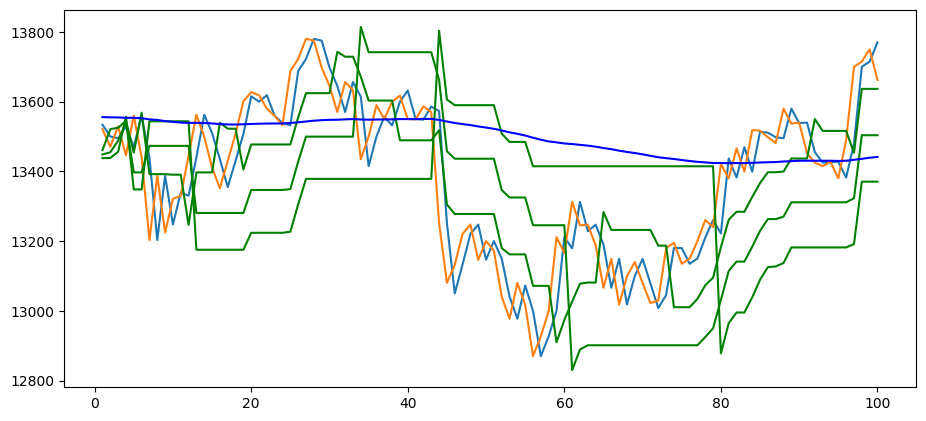

In [14]:
nmax=100
plt.figure(figsize=(11, 5), dpi=100)
plt.plot(data_f1[['open','close']].loc[1:nmax])
plt.plot(data_ST1.loc[1:nmax],'green')
plt.plot(data_ST2.loc[1:nmax],'green')
plt.plot(data_ST3.loc[1:nmax],'green')
plt.plot(data_ema['close'].loc[1:nmax],'blue')

# Stochastic RSI


In [15]:
def StochRSI(series, period=14, smoothK=3, smoothD=3):
    # Calculate RSI 
    delta = series.diff().dropna()
    ups = delta * 0
    downs = ups.copy()
    ups[delta > 0] = delta[delta > 0]
    downs[delta < 0] = -delta[delta < 0]
    ups[ups.index[period-1]] = np.mean( ups[:period] ) #first value is sum of avg gains
    ups = ups.drop(ups.index[:(period-1)])
    downs[downs.index[period-1]] = np.mean( downs[:period] ) #first value is sum of avg losses
    downs = downs.drop(downs.index[:(period-1)])
    rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / \
         downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() 
    rsi = 100 - 100 / (1 + rs)

    # Calculate StochRSI 
    stochrsi  = (rsi - rsi.rolling(period).min()) / (rsi.rolling(period).max() - rsi.rolling(period).min())
    stochrsi_K = stochrsi.rolling(smoothK).mean()
    stochrsi_D = stochrsi_K.rolling(smoothD).mean()

    return stochrsi, stochrsi_K, stochrsi_D

In [16]:
st=StochRSI(data_f1[['open']])

In [17]:
Sto=st[0]['open']
Sto_k=st[1]['open']
Sto_d=st[2]['open']

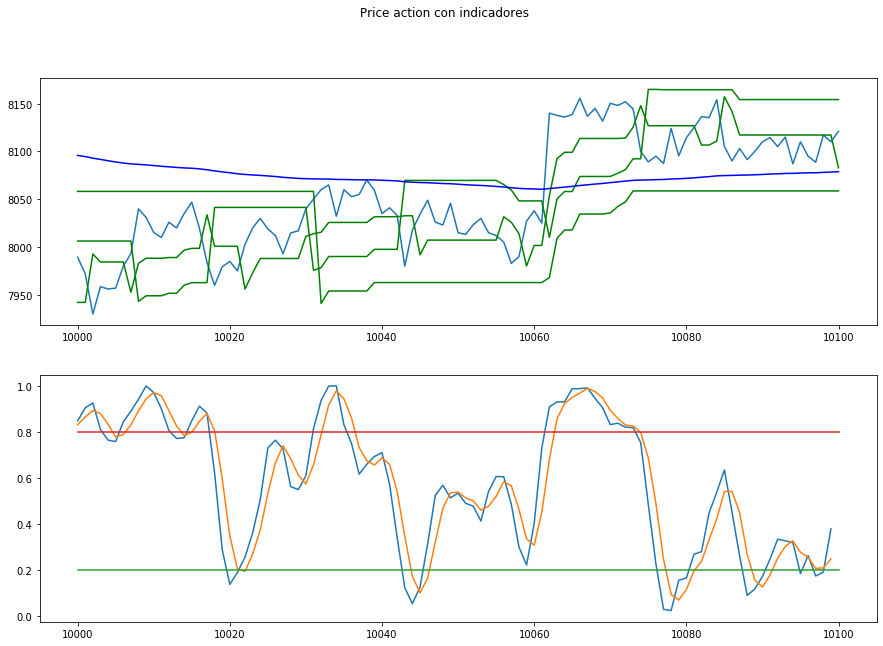

In [18]:
nmin=10000
nmax=10100
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Price action con indicadores')
fig.set_figheight(10)
fig.set_figwidth(15)

ax1.plot(data_f1[['close']].loc[nmin:nmax])
ax1.plot(data_ST1.loc[nmin:nmax],'green')
ax1.plot(data_ST2.loc[nmin:nmax],'green')
ax1.plot(data_ST3.loc[nmin:nmax],'green')
ax1.plot(data_ema['close'].loc[nmin:nmax],'blue')

ax2.plot(Sto_k[nmin-14:nmax-14])
ax2.plot(Sto_d[nmin-14:nmax-14])
ax2.plot([nmin,nmax],[0.2,0.2])
ax2.plot([nmin,nmax],[0.8,0.8])

# Trade Sim.

In [23]:
#long y short a tiempo fijo
def long_f(Data,size,entry,delta):
    pos_ini=size
    if entry+delta<len(Data):
        pos_fin=(size*Data['close'].loc[entry+delta])/(Data['close'].loc[entry])
    else:
        pos_fin=(size*Data['close'].loc[len(Data)-1])/(Data['close'].loc[entry])
    pnl=pos_fin-pos_ini
    return pnl

def short_f(Data,size,entry,delta):
    return -long_f(Data,size,entry,delta)

#long y short con stop loss y take profit
def long_tp(Data,size,entry,sl,tp):
    pos_ini=size
    i=1
    exit=entry
    delta=0
    while(i<len(Data)-entry):
        #print(Data['close'].loc[entry+i])
        if Data['low'].loc[entry+i]<sl:
            pos_fin=(size*sl)/(Data['close'].loc[entry])
            exit=entry+i
            break
        elif Data['high'].loc[entry+i]>tp:
            pos_fin=(size*tp)/(Data['close'].loc[entry])
            exit=entry+i
            break
        else :
            pos_fin=(size*Data['close'].loc[entry+i])/(Data['close'].loc[entry])
            exit=len(Data)
        i=i+1
    pnl=pos_fin-pos_ini
    delta=exit-entry
    return pnl, exit, delta     

def short_tp(Data,size,entry,sl,tp):
    aux=long_tp(Data,size,entry,tp,sl)
    return -aux[0],aux[1],aux[2]

In [70]:
short_tp(data_f1,1000,6160,11000,10000)

(57.76645422440993, 6165)

# Estrategia

In [21]:
#Señal de supertrends y EMA (sin Stoch. RSI)
def long_signal(Data,entry,ST1,ST2,ST3,EMA):
    ST_cond=Data['close'].loc[entry]>ST1.loc[entry] and Data['close'].loc[entry]>ST2.loc[entry] and Data['close'].loc[entry]>ST3.loc[entry]
    return ST_cond and Data['close'].loc[entry]>EMA['close'].loc[entry]
#long_signal(data_f1,10040,data_ST1,data_ST2,data_ST3,data_ema)
def short_signal(Data,entry,ST1,ST2,ST3,EMA):
    ST_cond=Data['close'].loc[entry]<ST1.loc[entry] and Data['close'].loc[entry]<ST2.loc[entry] and Data['close'].loc[entry]<ST3.loc[entry]
    return ST_cond and Data['close'].loc[entry]<EMA['close'].loc[entry]

# Backtesting

# Backtesting con tiempo fijo de hold

In [179]:
#Backtesting simple, sin condicion de Stocg RSI
def backtesting_f(Data,pos_ini,start,end,delta,ST1,ST2,ST3,EMA,com):
    i=0
    val_port=pos_ini
    port=np.zeros(end-start)
    port[0]=val_port
    while i<end-start:
        if long_signal(Data,start+i,ST1,ST2,ST3,EMA) :
            port[i]=val_port
            val_port=val_port+long_f(Data,val_port,start+i,delta)*(1-com)
            #print(i)
            for j in range(delta):
                port[j+i+1]=val_port
            i=i+delta+1
        elif short_signal(Data,start+i,ST1,ST2,ST3,EMA) :
            port[i]=val_port
            val_port=val_port+short_f(Data,val_port,start+i,delta)*(1-com)
            #print(i)
            for j in range(delta):
                port[j+i+1]=val_port
            i=i+delta+1          
        else :
            port[i]=val_port
            i=i+1
    return val_port,port

#Backtest
def backtesting_S_f(Data,pos_ini,start,end,delta,ST1,ST2,ST3,EMA,com,sto_k,sto_d):
    i=0
    val_port=pos_ini
    port=np.zeros(end-start)
    port[0]=val_port
    buy=False
    num_trades=0
    num_trades_suc=0
    while i<end-start:
        if sto_k[start+i]<=0.2 or sto_d[start+i]<=0.2 :
            buy=True
        elif sto_k[start+i]>=0.8 or sto_d[start+i]>=0.8 :
            buy=False
        if long_signal(Data,start+i,ST1,ST2,ST3,EMA) and buy :
            port[i]=val_port
            pnl=long_f(Data,val_port,start+i,delta)
            #Calculo de pnl con comision (?)
            if pnl>=0:
                pnl=pnl*(1-com)
            val_port=val_port+pnl
            num_trades=num_trades+1
            for j in range(delta):
                port[j+i+1]=val_port
            if pnl>=0:
                num_trades_suc=num_trades_suc+1
            i=i+delta+1
        elif short_signal(Data,start+i,ST1,ST2,ST3,EMA) and not buy:
            port[i]=val_port
            pnl=short_f(Data,val_port,start+i,delta)
            #Calculo de pnl con comision (?)
            if pnl>=0:
                pnl=pnl*(1-com)
            val_port=val_port+pnl
            num_trades=num_trades+1
            for j in range(delta):
                port[j+i+1]=val_port
            if pnl>=0:
                num_trades_suc=num_trades_suc+1
            i=i+delta+1          
        else :
            port[i]=val_port
            i=i+1
    return val_port,port , (num_trades_suc/num_trades)*100


# Backtesting con SL y TP

In [151]:
#Aun no funciona bien
def backtesting_S_sltp(Data,pos_ini,start,end,ST1,ST2,ST3,EMA,com,sto_k,sto_d):
    i=0
    val_port=pos_ini
    port=np.zeros(end-start)
    port[0]=val_port
    buy=False
    num_trades=0
    num_trades_suc=0
    while i<end-start:
        if sto_k[start+i]<=0.2 or sto_d[start+i]<=0.2 :
            buy=True
        if sto_k[start+i]>=0.8 or sto_d[start+i]>=0.8 :
            buy=False
        
        if long_signal(Data,start+i,ST1,ST2,ST3,EMA) and buy :
            port[i]=val_port
            SL=np.min(np.array([ST1.loc[start+i],ST2.loc[start+i],ST3.loc[start+i]]))
            pnl=long_tp(Data,val_port,start+i,1.5*SL,SL)
            #print(SL)
            #print(start+i)
            #print(pnl[2])
            delta=pnl[2]
            val_port=val_port+pnl[0]*(1-com)
            num_trades=num_trades+1
            for j in range(delta):
                port[j+i+1]=val_port
            if pnl[0]>=0:
                num_trades_suc=num_trades_suc+1
            i=pnl[1]+1
        elif short_signal(Data,start+i,ST1,ST2,ST3,EMA) and buy:
            port[i]=val_port
            SL=np.max(np.array([ST1.loc[start+i],ST2.loc[start+i],ST3.loc[start+i]]))
            pnl=short_tp(Data,val_port,start+i,1.5*SL,SL)
            #print(pnl)
            delta=pnl[2]
            val_port=val_port+pnl[0]*(1-com)
            num_trades=num_trades+1
            for j in range(delta):
                port[j+i+1]=val_port
            if pnl[0]>=0:
                num_trades_suc=num_trades_suc+1
            i=pnl[1]+1          
        else :
            port[i]=val_port
            i=i+1
    return val_port,port , (num_trades_suc/num_trades)*100

In [164]:
sol2=backtesting_S_sltp(data_f1,1000,nmin,nmax,data_ST1,data_ST2,data_ST3,data_ema,0.005,Sto_k,Sto_d)

(33.33333333333333, [<matplotlib.lines.Line2D at 0x1f8c3d310c8>])

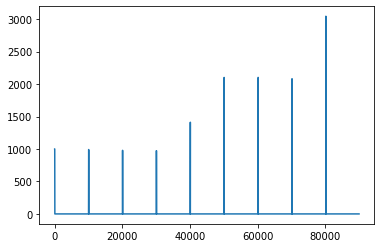

In [153]:
sol2[2],plt.plot(sol2[1])

# Resultados

In [29]:
nmin=100
nmax=118000

In [30]:
sol2=backtesting_S_f(data_f1,1000,nmin,nmax,5,data_ST1,data_ST2,data_ST3,data_ema,0.005,Sto_k,Sto_d)

(44.685138539042825, [<matplotlib.lines.Line2D at 0x2336b255648>])

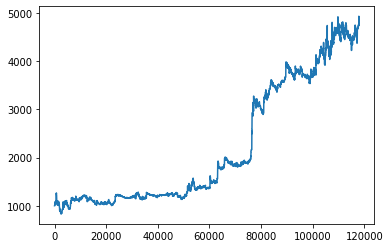

In [31]:
sol2[2],plt.plot(sol2[1])

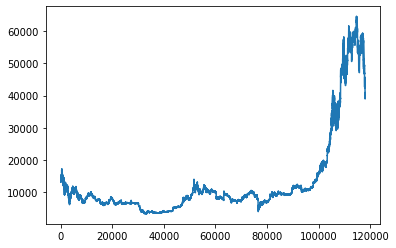

In [32]:
plt.plot(data_f1['close'].loc[nmin:nmax])

# Ctrl+s

In [1]:
import dill
#dill.dump_session('notebook_env.db')
#dill.load_session('notebook_env.db')

In [28]:
data_f1

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,...,tr0,tr1,tr2,TR,ATR,BUB,BLB,FUB,FLB,ST
0,13715.65,13715.65,13400.01,13556.15,123.616013,1.514766e+12,1.675545e+06,1572.0,63.227133,8.576108e+05,...,315.64,NaN,NaN,315.64,0.000000,13557.830000,13557.830000,0.000000,0.000000,0.000000
1,13533.75,13550.87,13402.00,13521.12,98.136430,1.514767e+12,1.321757e+06,1461.0,47.686389,6.422812e+05,...,148.87,5.28,154.15,154.15,12.845833,13514.972500,13437.897500,13514.972500,13437.897500,13437.897500
2,13500.00,13545.37,13450.00,13470.41,79.904037,1.514767e+12,1.078825e+06,1000.0,43.710406,5.900347e+05,...,95.37,24.25,71.12,95.37,19.722847,13556.853542,13438.516458,13556.853542,13438.516458,13438.516458
3,13494.65,13690.87,13450.00,13529.01,141.699719,1.514768e+12,1.917783e+06,1195.0,73.897993,1.000614e+06,...,240.87,220.46,20.41,240.87,38.151777,13684.890330,13455.979670,13556.853542,13455.979670,13455.979670
4,13528.99,13571.74,13402.28,13445.63,72.537533,1.514769e+12,9.778198e+05,898.0,34.257652,4.618369e+05,...,169.46,42.73,126.73,169.46,49.094129,13634.292386,13339.727614,13556.853542,13455.979670,13556.853542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119594,37088.37,37203.53,36462.42,36590.30,1148.240386,1.622848e+12,4.223552e+07,22875.0,509.614632,1.874720e+07,...,741.11,115.13,625.98,741.11,221.444433,37497.308298,36168.641702,37410.729196,36628.263675,37410.729196
119595,36590.30,36879.00,36491.47,36797.18,830.220657,1.622849e+12,3.047145e+07,14555.0,438.262073,1.608385e+07,...,387.53,288.70,98.83,387.53,235.284897,37391.089690,35979.380310,37391.089690,35979.380310,37391.089690
119596,36797.17,37110.92,36729.10,37045.16,522.528894,1.622850e+12,1.928658e+07,11927.0,259.774394,9.591163e+06,...,381.82,313.74,68.08,381.82,247.496155,37662.498466,36177.521534,37391.089690,36177.521534,37391.089690
119597,37046.05,37090.39,36765.64,36829.00,575.429355,1.622851e+12,2.123667e+07,10924.0,287.040056,1.059167e+07,...,324.75,45.23,279.52,324.75,253.933976,37689.816927,36166.213073,37391.089690,36177.521534,37391.089690
